In [296]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [297]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [298]:
NUM_CLASSES = 10

# 学習データ読み込み

In [299]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [300]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [302]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [303]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_28 (Dropout)        (None, 42)                0         
                                                                 
 dense_42 (Dense)            (None, 20)                860       
                                                                 
 dropout_29 (Dropout)        (None, 20)                0         
                                                                 
 dense_43 (Dense)            (None, 10)                210       
                                                                 
 dense_44 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [304]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [305]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [306]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
37/48 [======================>.......] - ETA: 0s - loss: 2.2762 - accuracy: 0.1609
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 2s 10ms/step - loss: 2.2590 - accuracy: 0.1699 - val_loss: 2.1571 - val_accuracy: 0.2898
Epoch 2/1000
41/48 [========================>.....] - ETA: 0s - loss: 2.1142 - accuracy: 0.2536
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 0s 5ms/step - loss: 2.1031 - accuracy: 0.2577 - val_loss: 1.9759 - val_accuracy: 0.3720
Epoch 3/1000
42/48 [=========================>....] - ETA: 0s - loss: 1.9670 - accuracy: 0.3129
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
48/48 [==============================] - 0s 5ms/step - loss: 1.9578 - accuracy: 0.3110 - val_loss: 1.7990 - val_accuracy: 0.4019
Epoch 4/1000
41/48 [========================>.....] - ETA: 0s - loss: 1.8564 - accuracy: 0.3439


In [307]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

16/16 [==============================] - 0s 2ms/step - loss: 0.6143 - accuracy: 0.8385


In [308]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [309]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 98ms/step
[4.4091912e-03 4.5243964e-02 7.4329431e-04 2.7158423e-04 1.1483085e-04
 7.1799457e-02 6.1170042e-01 2.4035105e-01 1.2407404e-02 1.2958719e-02]
6


# 混同行列

64/64 [==============================] - 0s 1ms/step


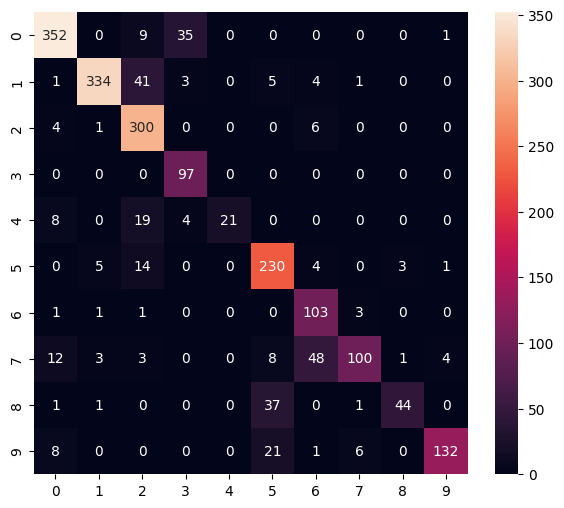

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       397
           1       0.97      0.86      0.91       389
           2       0.78      0.96      0.86       311
           3       0.70      1.00      0.82        97
           4       1.00      0.40      0.58        52
           5       0.76      0.89      0.82       257
           6       0.62      0.94      0.75       109
           7       0.90      0.56      0.69       179
           8       0.92      0.52      0.67        84
           9       0.96      0.79      0.86       168

    accuracy                           0.84      2043
   macro avg       0.85      0.78      0.79      2043
weighted avg       0.86      0.84      0.83      2043



In [310]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [311]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [312]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\nmosq\AppData\Local\Temp\tmp7j31zrx1\assets


INFO:tensorflow:Assets written to: C:\Users\nmosq\AppData\Local\Temp\tmp7j31zrx1\assets


6888

# 推論テスト

In [313]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [314]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [315]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [316]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [317]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.40918887e-03 4.52439263e-02 7.43292854e-04 2.71584082e-04
 1.14830735e-04 7.17994049e-02 6.11700416e-01 2.40351230e-01
 1.24074062e-02 1.29587166e-02]
6
